<a href="https://colab.research.google.com/github/giutassarotti/IAesame/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -r requirements.txt

#**Caricamento del dataframe**#

In [41]:
import pandas
import numpy

numpy.set_printoptions(precision=3, suppress=True)

def io_load_multiple_csv(csv_path_list):
  dataframe_list = []
  for elem in csv_path_list:
    dataframe_list.append(io_load_csv(elem))
  return dataframe_list

def io_load_csv(csv_path):
  return pandas.read_csv(csv_path)

In [68]:
dataframe_train_path = "train.csv"
dataframe_test_path = "test.csv"

dataframe_train, dataframe_test = io_load_multiple_csv([dataframe_train_path, dataframe_test_path])

Stampa delle prime righe:

In [58]:
dataframe_train.head()

,Exited,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0,6948,15809558,Peppin,715,Spain,Male,31,7,0.00,1,1,1,149970.59
1,1,1306,15800434,Burgess,811,Germany,Male,52,10,76915.40,1,0,0,146359.81
2,0,49,15766205,Yin,550,Germany,Male,38,2,103391.38,1,0,1,90878.13
3,0,8634,15801414,Bitter,767,France,Female,35,2,0.00,2,0,0,144251.38
4,0,8407,15578747,Chineze,701,Spain,Male,26,5,83600.24,1,0,1,59195.05


# **Analisi del dataset**
**Filtraggio dei valori nulli**

Grazie alla stampa dell'analisi delle colonne, fatta ad inizio esecuzione, è stato scoperto che nessuna colonna presenta righe con valori nulli o sbagliati.  

## **Analisi del dataframe**
Definiamo ora le funzioni utili ad analizzare il dataframe fornito.

In [69]:
def print_infos(dataframe):
  print("Informazioni del Dataframe:\n")
  print("Righe     : {}".format(dataframe.shape[0]) )
  print("Colonne  : {}".format(dataframe.shape[1]))
  print("\nFeatures :\n{}".format(dataframe.columns.tolist()))
  print("\nValori Unici :\n{}".format(dataframe.nunique()))

  print("\nInformazioni del Dataframe:")
  dataframe.info()

In [70]:
import matplotlib.pyplot as pyplot
import seaborn

def is_categorical(elem):
  return type(elem) is str

def is_numeric(elem):
  return not is_categorical(elem)

def get_numeric_features(dataframe):
  numeric_features = []
  for elem in dataframe:
    if is_numeric(dataframe[elem][0]):
      numeric_features.append(elem)
  return numeric_features

def get_categorical_features(dataframe):
  categorical_features = []
  for elem in dataframe:
    if is_categorical(dataframe[elem][0]):
      categorical_features.append(elem)
  return categorical_features

def print_feature_plots(dataframe, feature_target):
  categorical_features = get_categorical_features(dataframe)
  numeric_features = get_numeric_features(dataframe)
  for elem in dataframe:
    if elem == feature_target:
      continue
    if elem in categorical_features:
      #Categorical
      plot = seaborn.catplot(x = feature_target, 
                        col = elem, 
                        data = dataframe, 
                        kind = 'count')
    elif elem in numeric_features:
      #Numeric
      plot = seaborn.displot(data = dataframe,
                        x = elem,
                        hue = feature_target) 
  
    pyplot.show()

# **Modello**
Vengono sfruttate le possiilità offerte da una pipeline di sklearn per creare ed utilizzare il modello.

Come classificatore viene utilizzato l'algoritmo di Random Forest, che è un algoritmo di tipo Ensemble, e quindi sfrutta la combinazione di altri algoritmi più deboli ma opportunamente organizzati ed utilizzati per ottenere dei risultati soddisfacenti. In questo caso abbiamo una combinazione di classificatori di tipo Decision tree.

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder

def create_preprocessor(dataframe):
  numeric_features = get_numeric_features(dataframe)
  numeric_transformer = Pipeline(
      steps = [('imputer', SimpleImputer(strategy='median')),
               ('scaler', StandardScaler())])

  categorical_features = get_categorical_features(dataframe)
  categorical_transformer = Pipeline(
      steps=[('imputer', SimpleImputer(strategy='most_frequent')),
             ('onehot', OneHotEncoder(handle_unknown='ignore'))])

  return ColumnTransformer(
      transformers=[('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)])

def create_model(dataframe):
  preprocessor = create_preprocessor(dataframe)

  return Pipeline(
      steps = [('preprocessor', preprocessor),
               ('classifier', RandomForestClassifier())])
  
def train_model(model, dataframe_train, dataframe_train_target):
  model.fit(dataframe_train, dataframe_train_target)
  print('Training score: {}'.format(model.score(dataframe_train, dataframe_train_target)))
  return model

def print_test_model(model, dataframe_test, dataframe_test_target):
  preds = model.predict(dataframe_test)
  print('Test score: {}'.format(model.score(dataframe_test, dataframe_test_target)))
  print(classification_report(dataframe_test_target, preds))

#**Esecuzione**#
**Stampa delle informazioni**

In [72]:
print_infos(dataframe_train)

Informazioni del Dataframe:

Righe     : 6400
Colonne  : 14

Features :
['Exited', 'RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

Valori Unici :
Exited                2
RowNumber          6400
CustomerId         6400
Surname            2339
CreditScore         446
Geography             3
Gender                2
Age                  67
Tenure               11
Balance            4107
NumOfProducts         4
HasCrCard             2
IsActiveMember        2
EstimatedSalary    6399
dtype: int64

Informazioni del Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Exited           6400 non-null   int64  
 1   RowNumber        6400 non-null   int64  
 2   CustomerId       6400 non-null   int64  
 3   Surname   

**Stampa dei grafici**

Si tratta di grafici che prendono come ascissa sempre la feature "Exited", ossia mettono a confronto ogni altra feature con la feature che ci interessa prevedere.

Nota: Vengono escluse le colonne "CustomerId" e "RowNumber" in quanto gli ID ed il numero di riga sono numeri casuali per identificare le persone, non hanno informazioni.
Stesso processo per "Surname" in quanto il cognome non influenza nulla.

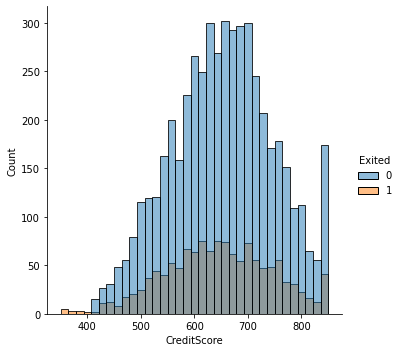

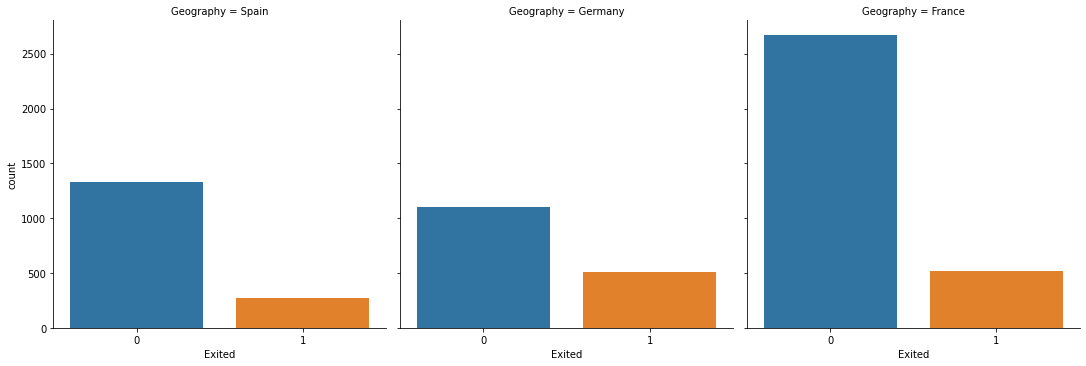

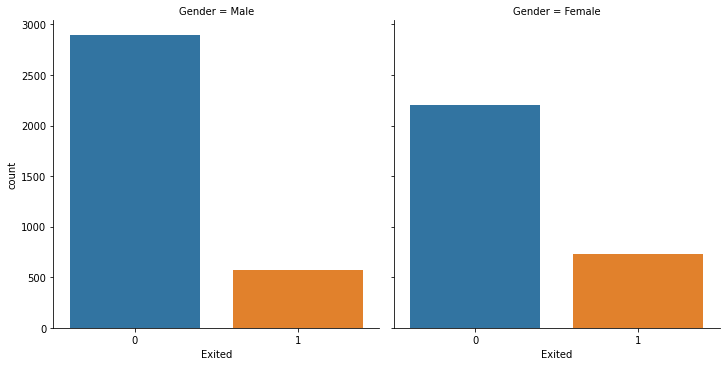

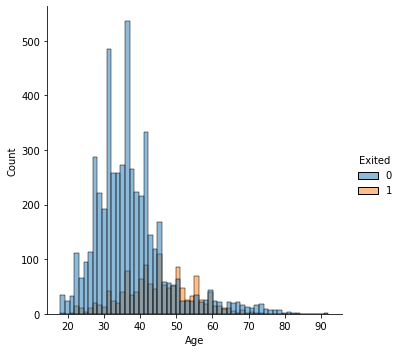

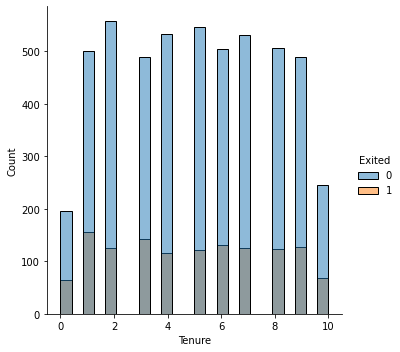

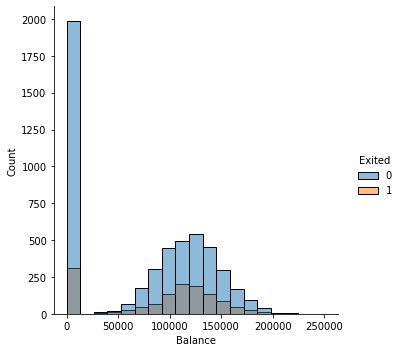

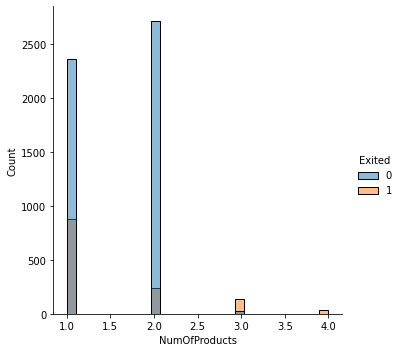

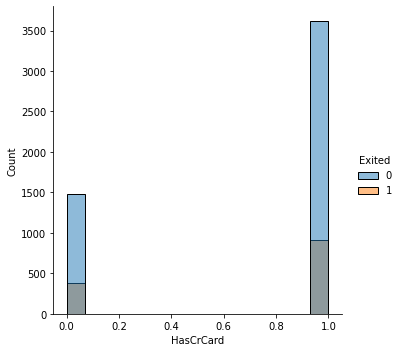

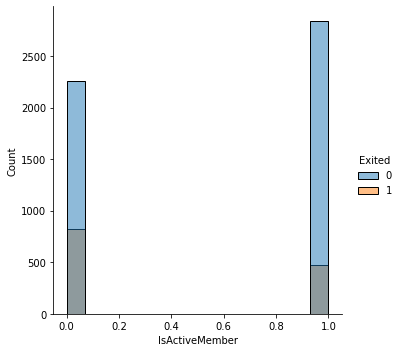

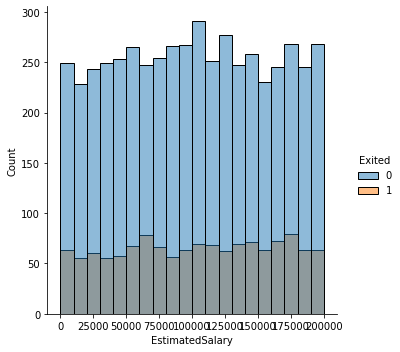

In [73]:
feature_target = "Exited"
dataframe_train.pop("CustomerId")
dataframe_train.pop("Surname")
dataframe_train.pop("RowNumber")
print_feature_plots(dataframe_train, feature_target)

##**Preparazione della feature target**##

In [74]:
le = LabelEncoder()

dataframe_train_target = le.fit_transform(dataframe_train.pop(feature_target))
dataframe_test_target = le.transform(dataframe_test.pop(feature_target))

#**Classificatore**#

In [ ]:
#Colonne da cancellare?

In [75]:
dataframe_train = dataframe_train.drop_duplicates()

classifier = create_model(dataframe_train)

classifier = train_model(classifier, dataframe_train, dataframe_train_target)

print_test_model(classifier, dataframe_test, dataframe_test_target)

Training score: 0.99984375
Test score: 0.851875
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1255
           1       0.77      0.45      0.57       345

    accuracy                           0.85      1600
   macro avg       0.82      0.71      0.74      1600
weighted avg       0.84      0.85      0.84      1600



/usr/local/lib/python3.7/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
